## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [5]:
from covid_data import CovidData
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline, WidgetControl
)

from ipywidgets import HTML

In [31]:
covid_data_manager = CovidData()

bin_region_column = 'state'
covid_data, routes_data = covid_data_manager.getData(bin_region_column=bin_region_column)
data_confirmed = covid_data['confirmed']
border_closures = covid_data_manager.loadBorderDataset()
data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20
0,Alabama,US,32.884280,-86.710122,0,0,0,0,0,0,...,11101,11373,11674,11771,12086,12376,13052,13288,13670,14117.0
1,Alaska,US,60.261375,-145.838598,0,0,0,0,0,0,...,379,387,387,387,387,399,401,401,403,407.0
2,Alberta,Canada,53.933300,-116.576500,0,0,0,0,0,0,...,6457,6515,6587,6644,6683,6716,6735,6768,6800,6818.0
3,American Samoa,US,-14.271000,-170.132000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,none,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,375,375,376,381,388,391,398,423,423,423.0
317,none,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6.0
318,none,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,85,106,122,128,130,167,184,197,209,212.0
319,none,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,654,654,679,753,761,772,832,866,920,920.0


In [36]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]

def clean_routes(routes, bin_region_column):
    if bin_region_column == 'county':
        return routes.loc[~((routes['DepartCounty'] == routes['ArrivalCounty']) &
                            (routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    elif bin_region_column == 'state':
        return routes.loc[~((routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    else:
        return routes.loc[~(routes['DepartCountry/Region'] == routes['ArrivalCountry/Region'])]
    
data_confirmed = clean_data(data_confirmed)
routes = clean_routes(routes_data, bin_region_column)

In [126]:
def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def route_indexes_between_nodes(node_loc_0, node_loc_1, routes, bin_region_column):
        node_loc_names_0 = node_loc_0.split(':')
        node_loc_names_1 = node_loc_1.split(':')
        
        if bin_region_column == 'county':
            from_0_to_1 = ((routes['DepartCounty'] == node_loc_names_0[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_0[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_1[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[2]))
            
            from_1_to_0 = ((routes['DepartCounty'] == node_loc_names_1[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_1[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_0[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[2]))
        elif bin_region_column == 'state':
            from_0_to_1 = ((routes['DepartProvince/State'] == node_loc_names_0[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[1]))
            
            from_1_to_0 = ((routes['DepartProvince/State'] == node_loc_names_1[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[1]))
        else:
            from_0_to_1 = ((routes['DepartCountry/Region'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[0]))
            
            from_1_to_0 = ((routes['DepartCountry/Region'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[0]))
        return from_0_to_1, from_1_to_0
    
def get_cases_on_date(name_loc, data_confirmed, date, bin_region_column):
    name_loc_split = name_loc.split(':')
    if bin_region_column == 'county':
        return data_confirmed.loc[(data_confirmed['County'] == name_loc_split[0]) &
                                  (data_confirmed['Province/State'] == name_loc_split[1]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[2])][date]
    elif bin_region_column == 'state':
        return data_confirmed.loc[(data_confirmed['Province/State'] == name_loc_split[0]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[1])][date]
    else:
        return data_confirmed.loc[(data_confirmed['Country/Region'] == name_loc_split[0])][date]
    
def get_dates(data_confirmed, bin_region_column):
    if bin_region_column == 'county':
        return data_confirmed.columns.tolist()[5:]
    if bin_region_column == 'state':
        return data_confirmed.columns.tolist()[4:]
    if bin_region_column == 'country':
        return data_confirmed.columns.tolist()[3:]

def get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column, border_closures = None):
    if not border_closures == None:
        assert bin_region_column == 'state' or bin_region_column == 'country', "Can only use border closures for state and country analysis"
    
    def get_loc_name(df_row, bin_region_column=bin_region_column):
        if bin_region_column == 'county':
            return "{}:{}:{}".format(df_row['County'], df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'state':
            return "{}:{}".format(df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'country':
            return "{}".format(df_row['Country/Region'])
        return None
    
    def get_initial_case(data_confirmed, dates):
        first_date = dates[0]
        return data_confirmed.sort_values(first_date).iloc[-1]
    
    def get_latest_date_index_of_lockdown(border_closures, date, dates):
        dates_list = [bc_dets['date'] for bc_dets in border_closures]
        #print(dates_list)
        date_index = dates.index(date)
        max_index = -1
        for test_index_bc in range(len(dates_list)):
            test_index_dates = dates.index(dates_list[test_index_bc])
            #print(test_index, date_index)
            if test_index_bc > max_index and test_index_dates <= date_index: 
                max_index = test_index_bc
                
        #print("MAX: {}".format(max_index))
        return max_index
    
    def in_lock(loc1_split, border_closure, date, dates):
        if not border_closure == None:
            latest_date_index = get_latest_date_index_of_lockdown(border_closure, date, dates)
            if not latest_date_index == -1: 
                whitelist = border_closure[latest_date_index]['whitelist']
                blacklist = border_closure[latest_date_index]['blacklist']

                if len(blacklist) > 0:
                    if loc1_split[-1] in blacklist:
                        return True
                elif not loc1_split[-1] in whitelist:
                    return True
        return False
    
    def loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
        
        loc0_split = loc0.split(':')
        loc1_split = loc1.split(':')
        
        if bin_region_column == 'state':
            state = loc0_split[0]
            country = loc0_split[1]
            
            if not state == 'none':
                border_closure = border_closures['state'].get("{}:{}".format(state,country), None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
            else:
                border_closure = border_closures['country'].get(country, None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
        else:
            country = loc0_split[0]
            border_closure = border_closures['country'].get(country, None)
            if in_lock(loc1_split, border_closure, date, dates):
                return True
        return False
    
    def check_for_lockdowns(loc0, loc1, date, dates, border_closures, bin_region_column):
        if border_closures == None: return False
        
        if loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
            return True
        elif loc0_disallow_loc1(loc1, loc0, date, dates, border_closures, bin_region_column):
            return True
        return False  
        
    
    infect_graph = nx.Graph()
    dates = get_dates(data_confirmed, bin_region_column)
    case_zero = get_initial_case(data_confirmed, dates)
    case_zero_name = get_loc_name(case_zero)
    infect_graph.add_node(case_zero_name)
    location_pos = {case_zero_name : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}
    infected_parents = {case_zero_name : []}
    new_locs = {dates[0] : [case_zero_name]}
    new_edges = {}

    for date in tqdm(dates):
        if not date == dates[0]:
            new_locs[date] = []
        
        new_edges[date] = []
        
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        
        for _index, row in conf_sort_day.iterrows():
            node_loc = get_loc_name(row)
            
            if not infect_graph.has_node(node_loc):
                already_infected = infect_graph.nodes
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(node_loc, pos=coords)
                infected_parents[node_loc] = []
                location_pos[node_loc] = coords
                new_locs[date] = new_locs[date] + [node_loc]
                # connect_to_infect = False - eventually for getting a connected graph
                
                for infected in already_infected:
                    from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, node_loc, routes, bin_region_column)
                    
                    if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                        if not check_for_lockdowns(node_loc, infected, date, dates, border_closures, bin_region_column):
                            infect_graph.add_edge(infected, node_loc)
                            new_edges[date] = new_edges[date] + [(infected, node_loc)]
                            infected_parents[infected] = infected_parents[infected] + [node_loc]
                
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges

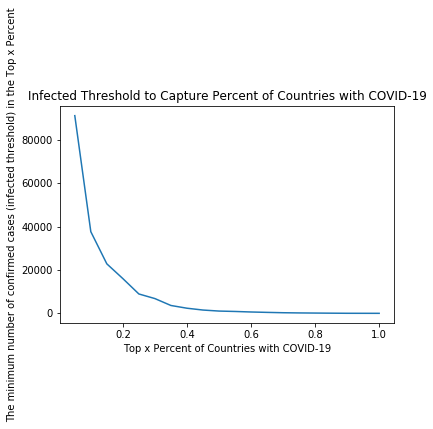

In [94]:
plt.plot([xx for xx in np.arange(0.05, 1.05, 0.05)], 
         [ get_initial_infect_thresh(data_confirmed, xx) for xx in np.arange(0.05, 1.05, 0.05)])
plt.title("Infected Threshold to Capture Percent of Countries with COVID-19")
plt.xlabel("Top x Percent of Countries with COVID-19")
plt.ylabel("The minimum number of confirmed cases (infected threshold) in the Top x Percent")
plt.show()

In [95]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 1.0)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges = get_infection_path(data_confirmed, 
                                                                                                       routes, 
                                                                                                       infect_thresh, 
                                                                                                       bin_region_column,
                                                                                                       border_closures=border_closures)

  0%|          | 0/123 [00:00<?, ?it/s]

INITIAL INFECTION THRESHOLD SET TO 1
1/22/20


  1%|          | 1/123 [00:01<03:57,  1.95s/it]

1/23/20


  2%|▏         | 2/123 [00:03<03:29,  1.73s/it]

1/24/20


  2%|▏         | 3/123 [00:03<02:45,  1.38s/it]

1/25/20


  3%|▎         | 4/123 [00:04<02:16,  1.15s/it]

1/26/20


  4%|▍         | 5/123 [00:05<02:11,  1.12s/it]

1/27/20


  5%|▍         | 6/123 [00:06<01:55,  1.01it/s]

1/28/20


  6%|▌         | 7/123 [00:06<01:29,  1.30it/s]

1/29/20


  7%|▋         | 8/123 [00:07<01:28,  1.31it/s]

1/30/20


  7%|▋         | 9/123 [00:07<01:31,  1.24it/s]

1/31/20


  8%|▊         | 10/123 [00:09<01:40,  1.12it/s]

2/1/20


  9%|▉         | 11/123 [00:09<01:39,  1.13it/s]

2/2/20
2/3/20
2/4/20


 11%|█▏        | 14/123 [00:10<01:11,  1.53it/s]

2/5/20
2/6/20
2/7/20
2/8/20
2/9/20
2/10/20
2/11/20
2/12/20
2/13/20
2/14/20


 20%|█▉        | 24/123 [00:10<00:46,  2.12it/s]

2/15/20
2/16/20
2/17/20
2/18/20
2/19/20


 24%|██▎       | 29/123 [00:11<00:33,  2.85it/s]

2/20/20
2/21/20


 25%|██▌       | 31/123 [00:11<00:32,  2.84it/s]

2/22/20
2/23/20
2/24/20


 28%|██▊       | 34/123 [00:13<00:36,  2.41it/s]

2/25/20


 28%|██▊       | 35/123 [00:14<01:02,  1.40it/s]

2/26/20


 29%|██▉       | 36/123 [00:17<01:52,  1.29s/it]

2/27/20


 30%|███       | 37/123 [00:19<02:02,  1.42s/it]

2/28/20


 31%|███       | 38/123 [00:22<02:44,  1.93s/it]

2/29/20


 32%|███▏      | 39/123 [00:25<03:03,  2.19s/it]

3/1/20


 33%|███▎      | 40/123 [00:28<03:19,  2.40s/it]

3/2/20


 33%|███▎      | 41/123 [00:33<04:37,  3.38s/it]

3/3/20


 34%|███▍      | 42/123 [00:37<04:33,  3.38s/it]

3/4/20


 35%|███▍      | 43/123 [00:41<05:04,  3.81s/it]

3/5/20


 36%|███▌      | 44/123 [00:47<05:52,  4.46s/it]

3/6/20


 37%|███▋      | 45/123 [00:59<08:24,  6.47s/it]

3/7/20


 37%|███▋      | 46/123 [01:04<07:48,  6.08s/it]

3/8/20


 38%|███▊      | 47/123 [01:11<08:02,  6.35s/it]

3/9/20


 39%|███▉      | 48/123 [01:15<07:04,  5.66s/it]

3/10/20


 40%|███▉      | 49/123 [01:21<07:02,  5.71s/it]

3/11/20


 41%|████      | 50/123 [01:32<09:02,  7.43s/it]

3/12/20


 41%|████▏     | 51/123 [01:38<08:15,  6.89s/it]

3/13/20
LOCKDOWN BETWEEN none:Ethiopia AND none:Israel


 42%|████▏     | 52/123 [01:54<11:21,  9.59s/it]

3/14/20
LOCKDOWN BETWEEN none:Suriname AND none:Brazil
LOCKDOWN BETWEEN none:Suriname AND none:Netherlands
LOCKDOWN BETWEEN none:Suriname AND Florida:US
LOCKDOWN BETWEEN none:Suriname AND French Guiana:France
LOCKDOWN BETWEEN none:Suriname AND none:Guyana
LOCKDOWN BETWEEN none:Suriname AND Aruba:Netherlands
LOCKDOWN BETWEEN Curacao:Netherlands AND none:Suriname
LOCKDOWN BETWEEN none:Trinidad and Tobago AND none:Suriname


 43%|████▎     | 53/123 [02:13<14:30, 12.44s/it]

3/15/20
LOCKDOWN BETWEEN Newfoundland and Labrador:Canada AND none:Israel
LOCKDOWN BETWEEN none:Uzbekistan AND none:Israel


 44%|████▍     | 54/123 [02:20<12:41, 11.03s/it]

3/16/20
LOCKDOWN BETWEEN none:Bahamas AND none:Norway
LOCKDOWN BETWEEN none:Bahamas AND none:Panama
LOCKDOWN BETWEEN Greenland:Denmark AND none:Denmark
LOCKDOWN BETWEEN none:Tanzania AND none:Oman
LOCKDOWN BETWEEN none:Tanzania AND none:Qatar
LOCKDOWN BETWEEN none:Tanzania AND none:Poland
LOCKDOWN BETWEEN none:Somalia AND none:Saudi Arabia
LOCKDOWN BETWEEN Puerto Rico:US AND none:Sweden
LOCKDOWN BETWEEN Puerto Rico:US AND none:Norway
LOCKDOWN BETWEEN Puerto Rico:US AND none:Denmark
LOCKDOWN BETWEEN Puerto Rico:US AND none:Panama


 45%|████▍     | 55/123 [02:33<13:04, 11.54s/it]

3/17/20
LOCKDOWN BETWEEN none:Gambia AND none:Spain
LOCKDOWN BETWEEN none:Gambia AND none:Belgium
LOCKDOWN BETWEEN none:Gambia AND none:Netherlands
LOCKDOWN BETWEEN none:Gambia AND none:Ghana
LOCKDOWN BETWEEN none:Montenegro AND none:France
LOCKDOWN BETWEEN none:Montenegro AND none:Germany
LOCKDOWN BETWEEN none:Montenegro AND none:Sweden
LOCKDOWN BETWEEN none:Montenegro AND none:Italy
LOCKDOWN BETWEEN none:Montenegro AND none:Belgium
LOCKDOWN BETWEEN none:Montenegro AND none:Switzerland
LOCKDOWN BETWEEN none:Montenegro AND none:Austria
LOCKDOWN BETWEEN none:Montenegro AND none:Greece
LOCKDOWN BETWEEN none:Montenegro AND none:Denmark
LOCKDOWN BETWEEN none:Montenegro AND none:Czechia
LOCKDOWN BETWEEN none:Montenegro AND none:Hungary
LOCKDOWN BETWEEN none:Montenegro AND none:Slovenia
LOCKDOWN BETWEEN none:Montenegro AND none:Serbia
LOCKDOWN BETWEEN none:Montenegro AND none:Moldova
LOCKDOWN BETWEEN none:Barbados AND none:Germany
LOCKDOWN BETWEEN none:Barbados AND none:Spain
LOCKDOWN BETWEE

 46%|████▌     | 56/123 [02:37<10:14,  9.18s/it]

LOCKDOWN BETWEEN none:Barbados AND none:Trinidad and Tobago
3/18/20
LOCKDOWN BETWEEN none:Djibouti AND none:France
LOCKDOWN BETWEEN none:Djibouti AND none:Qatar
LOCKDOWN BETWEEN none:Djibouti AND none:Saudi Arabia
LOCKDOWN BETWEEN none:Djibouti AND none:Kenya
LOCKDOWN BETWEEN none:Djibouti AND none:Sudan
LOCKDOWN BETWEEN none:Zambia AND none:Kenya
LOCKDOWN BETWEEN none:Kyrgyzstan AND none:Russia
LOCKDOWN BETWEEN none:Mauritius AND none:France
LOCKDOWN BETWEEN none:Mauritius AND none:Malaysia
LOCKDOWN BETWEEN none:Mauritius AND none:Germany
LOCKDOWN BETWEEN none:Mauritius AND none:Spain
LOCKDOWN BETWEEN none:Mauritius AND none:Switzerland
LOCKDOWN BETWEEN none:Mauritius AND none:Austria
LOCKDOWN BETWEEN none:Mauritius AND none:Netherlands


 46%|████▋     | 57/123 [02:44<09:29,  8.63s/it]

3/19/20
LOCKDOWN BETWEEN none:Fiji AND none:New Zealand
LOCKDOWN BETWEEN none:Nicaragua AND none:Costa Rica
LOCKDOWN BETWEEN none:Nicaragua AND none:Panama
LOCKDOWN BETWEEN none:Nicaragua AND none:Honduras
LOCKDOWN BETWEEN none:Nicaragua AND none:Guatemala
LOCKDOWN BETWEEN none:Chad AND none:France
LOCKDOWN BETWEEN none:Chad AND none:Egypt
LOCKDOWN BETWEEN none:El Salvador AND Illinois:US
LOCKDOWN BETWEEN none:El Salvador AND Ontario:Canada
LOCKDOWN BETWEEN none:El Salvador AND California:US
LOCKDOWN BETWEEN none:El Salvador AND none:Spain
LOCKDOWN BETWEEN none:El Salvador AND Massachusetts:US
LOCKDOWN BETWEEN none:El Salvador AND none:Mexico
LOCKDOWN BETWEEN none:El Salvador AND none:Ecuador
LOCKDOWN BETWEEN none:El Salvador AND Florida:US
LOCKDOWN BETWEEN none:El Salvador AND New York:US
LOCKDOWN BETWEEN none:El Salvador AND none:Chile
LOCKDOWN BETWEEN none:El Salvador AND Georgia:US
LOCKDOWN BETWEEN none:El Salvador AND New Jersey:US
LOCKDOWN BETWEEN none:El Salvador AND Texas:US
LO

 47%|████▋     | 58/123 [02:52<08:59,  8.30s/it]

3/20/20
LOCKDOWN BETWEEN none:Cabo Verde AND none:France
LOCKDOWN BETWEEN none:Cabo Verde AND none:Germany
LOCKDOWN BETWEEN none:Cabo Verde AND none:Italy
LOCKDOWN BETWEEN none:Cabo Verde AND none:Spain
LOCKDOWN BETWEEN none:Cabo Verde AND none:Belgium
LOCKDOWN BETWEEN none:Cabo Verde AND none:Switzerland
LOCKDOWN BETWEEN none:Cabo Verde AND none:Netherlands
LOCKDOWN BETWEEN none:Cabo Verde AND none:Luxembourg
LOCKDOWN BETWEEN none:Cabo Verde AND none:Portugal
LOCKDOWN BETWEEN none:Niger AND none:France
LOCKDOWN BETWEEN none:Angola AND none:France
LOCKDOWN BETWEEN none:Angola AND none:Germany
LOCKDOWN BETWEEN none:Angola AND none:United Arab Emirates
LOCKDOWN BETWEEN none:Angola AND none:Belgium
LOCKDOWN BETWEEN none:Angola AND none:Netherlands
LOCKDOWN BETWEEN none:Angola AND none:Portugal
LOCKDOWN BETWEEN none:Angola AND none:Kenya
LOCKDOWN BETWEEN Sint Maarten:Netherlands AND none:Panama
LOCKDOWN BETWEEN Sint Maarten:Netherlands AND none:Jamaica
LOCKDOWN BETWEEN none:Papua New Guine

 48%|████▊     | 59/123 [03:03<09:55,  9.31s/it]

3/21/20
LOCKDOWN BETWEEN none:Uganda AND none:United Arab Emirates
LOCKDOWN BETWEEN none:Uganda AND none:Belgium
LOCKDOWN BETWEEN none:Uganda AND none:Egypt
LOCKDOWN BETWEEN none:Uganda AND none:Netherlands
LOCKDOWN BETWEEN none:Uganda AND none:Qatar
LOCKDOWN BETWEEN none:Uganda AND none:Kenya
LOCKDOWN BETWEEN none:Eritrea AND none:United Arab Emirates
LOCKDOWN BETWEEN none:Eritrea AND none:Egypt
LOCKDOWN BETWEEN none:Eritrea AND none:Qatar
LOCKDOWN BETWEEN none:Eritrea AND none:Saudi Arabia
LOCKDOWN BETWEEN none:Eritrea AND none:Sudan


 49%|████▉     | 60/123 [03:06<07:40,  7.32s/it]

3/22/20
LOCKDOWN BETWEEN none:Mozambique AND none:Qatar
LOCKDOWN BETWEEN none:Mozambique AND none:Portugal
LOCKDOWN BETWEEN none:Mozambique AND none:Kenya
LOCKDOWN BETWEEN none:Grenada AND none:Trinidad and Tobago
LOCKDOWN BETWEEN none:Syria AND none:Oman
LOCKDOWN BETWEEN none:Syria AND none:Sudan


 50%|████▉     | 61/123 [03:13<07:22,  7.14s/it]

3/23/20
LOCKDOWN BETWEEN none:Belize AND none:Panama
LOCKDOWN BETWEEN none:Belize AND none:Honduras
LOCKDOWN BETWEEN none:Belize AND none:Guatemala


 50%|█████     | 62/123 [03:14<05:31,  5.43s/it]

LOCKDOWN BETWEEN none:Belize AND none:El Salvador
3/24/20
LOCKDOWN BETWEEN none:Libya AND none:United Arab Emirates
LOCKDOWN BETWEEN none:Libya AND none:Egypt
LOCKDOWN BETWEEN none:Libya AND none:Saudi Arabia
LOCKDOWN BETWEEN none:Libya AND none:Jordan
LOCKDOWN BETWEEN none:Libya AND none:Sudan
LOCKDOWN BETWEEN none:Libya AND none:Ghana
LOCKDOWN BETWEEN none:Laos AND none:Singapore
LOCKDOWN BETWEEN none:Laos AND none:Vietnam
LOCKDOWN BETWEEN none:Laos AND none:Malaysia


 51%|█████     | 63/123 [03:17<04:39,  4.65s/it]

3/25/20
LOCKDOWN BETWEEN none:Guinea-Bissau AND none:Portugal
LOCKDOWN BETWEEN none:Mali AND none:France
LOCKDOWN BETWEEN none:Mali AND none:Kenya
LOCKDOWN BETWEEN none:Mali AND none:Congo (Brazzaville)


 52%|█████▏    | 64/123 [03:21<04:26,  4.51s/it]

3/26/20
LOCKDOWN BETWEEN Yukon:Canada AND none:Germany


 53%|█████▎    | 65/123 [03:25<04:16,  4.42s/it]

3/27/20
LOCKDOWN BETWEEN none:Burma AND none:Taiwan*
LOCKDOWN BETWEEN none:Burma AND none:Japan
LOCKDOWN BETWEEN none:Burma AND none:Thailand
LOCKDOWN BETWEEN none:Burma AND none:Singapore
LOCKDOWN BETWEEN none:Burma AND none:Vietnam
LOCKDOWN BETWEEN none:Burma AND Hong Kong:China
LOCKDOWN BETWEEN none:Burma AND none:Malaysia
LOCKDOWN BETWEEN none:Burma AND none:United Arab Emirates
LOCKDOWN BETWEEN none:Burma AND none:India
LOCKDOWN BETWEEN none:Burma AND none:Qatar


 54%|█████▎    | 66/123 [03:27<03:21,  3.54s/it]

3/28/20
LOCKDOWN BETWEEN Anguilla:United Kingdom AND none:Dominica
LOCKDOWN BETWEEN British Virgin Islands:United Kingdom AND none:Dominica
LOCKDOWN BETWEEN Turks and Caicos Islands:United Kingdom AND none:Jamaica
LOCKDOWN BETWEEN Turks and Caicos Islands:United Kingdom AND none:Cuba


 54%|█████▍    | 67/123 [03:31<03:30,  3.76s/it]

3/29/20
3/30/20
LOCKDOWN BETWEEN none:Botswana AND none:South Africa


 56%|█████▌    | 69/123 [03:33<02:34,  2.86s/it]

LOCKDOWN BETWEEN none:Botswana AND none:Kenya
3/31/20
LOCKDOWN BETWEEN none:Sierra Leone AND none:Nigeria
LOCKDOWN BETWEEN none:Sierra Leone AND none:Ghana
LOCKDOWN BETWEEN none:Burundi AND none:Belgium
LOCKDOWN BETWEEN none:Burundi AND none:Kenya
LOCKDOWN BETWEEN Northern Mariana Islands:US AND none:Japan
LOCKDOWN BETWEEN Northern Mariana Islands:US AND Hong Kong:China
LOCKDOWN BETWEEN Northern Mariana Islands:US AND none:Philippines


 57%|█████▋    | 70/123 [03:37<02:54,  3.30s/it]

4/1/20
4/2/20
LOCKDOWN BETWEEN none:Malawi AND none:South Africa
LOCKDOWN BETWEEN none:Malawi AND none:Congo (Kinshasa)
LOCKDOWN BETWEEN none:Malawi AND none:Kenya


 59%|█████▊    | 72/123 [03:40<02:20,  2.75s/it]

4/3/20
4/4/20
LOCKDOWN BETWEEN Falkland Islands (Malvinas):United Kingdom AND none:Argentina


 60%|██████    | 74/123 [03:41<01:45,  2.15s/it]

4/5/20
LOCKDOWN BETWEEN none:South Sudan AND none:United Arab Emirates
LOCKDOWN BETWEEN none:South Sudan AND none:Egypt
LOCKDOWN BETWEEN none:South Sudan AND none:Kenya
LOCKDOWN BETWEEN none:South Sudan AND none:Sudan


 61%|██████    | 75/123 [03:46<02:16,  2.85s/it]

4/6/20
LOCKDOWN BETWEEN none:Sao Tome and Principe AND none:Portugal


 64%|██████▍   | 79/123 [03:48<01:16,  1.73s/it]

4/7/20
4/8/20
4/9/20
4/10/20


 70%|██████▉   | 86/123 [03:49<00:31,  1.19it/s]

4/11/20
4/12/20
4/13/20
4/14/20
4/15/20
4/16/20
4/17/20


 75%|███████▍  | 92/123 [03:50<00:13,  2.31it/s]

4/18/20
4/19/20
4/20/20
4/21/20
4/22/20
4/23/20
4/24/20


 80%|███████▉  | 98/123 [03:50<00:05,  4.32it/s]

4/25/20
4/26/20
4/27/20
4/28/20
4/29/20
4/30/20


 85%|████████▍ | 104/123 [03:53<00:06,  2.93it/s]

5/1/20
5/2/20
5/3/20
5/4/20
5/5/20
5/6/20


 89%|████████▉ | 110/123 [03:53<00:02,  5.37it/s]

5/7/20
5/8/20
5/9/20
5/10/20
5/11/20
5/12/20


 97%|█████████▋| 119/123 [03:55<00:00,  6.17it/s]

5/13/20
5/14/20
5/15/20
5/16/20
5/17/20
5/18/20
5/19/20
5/20/20


100%|██████████| 123/123 [03:55<00:00,  1.92s/it]

5/21/20
5/22/20
5/23/20


In [123]:
class TimeMapAnimation:

    def __init__(self, infect_graphs, location_pos, data_confirmed, routes, new_locs, new_edges, bin_region_column, 
                 date_list=None, zoom=1.0, scale=3, dynamic_line_opacity=False, line_opacity=0.02, center = (0,0), 
                 date_msg_format = '<p style="color:red">Date: <b>{date}</b></p>', verbose=False, period=1.0, 
                 wait_time=5.0):
        
        self.infect_graphs = infect_graphs
        self.location_pos = location_pos
        self.data_confirmed = data_confirmed
        self.routes = routes  
        self.new_locs = new_locs
        self.new_edges = new_edges
        self.bin_region_column = bin_region_column
        
        self.dates = get_dates(self.data_confirmed, self.bin_region_column) if date_list == None else date_list
        self.date_msg_format = date_msg_format
        self.date_msg = HTML()
        self._updateDateMsg(self.dates[0])
        
        self.verbose = verbose
        self.period = period
        self.line_opacity = line_opacity
        self.scale = scale
        self.wait_time = wait_time
        self.dynamic_line_opacity = dynamic_line_opacity
        
        if self.dynamic_line_opacity:
            self.line_opacity_fn = lambda routes_between, max_routes: routes_between/max_routes
        else:
            self.line_opacity_fn = lambda routes_between, max_routes: self.line_opacity
        
        self.marker_layer = None
        self.circle_layer = None
        self.line_layer = None
        
        self.time_infection_map = Map(basemap=basemaps.CartoDB.DarkMatter, 
                                      center=(0,0), 
                                      zoom=zoom,
                                      scroll_wheel_zoom=True,
                                     )
        self.time_infection_map.add_control(FullScreenControl())
        self.time_infection_map.add_control(WidgetControl(widget=self.date_msg, position='topright'))
        
    def displayMap(self):
        """
        This function needs to be called on last line of a Jupyter Notebook cell to display the Map
        """
        return self.time_infection_map
    
    def startAnimation(self):
        self._clearLayers()
        
        self._print("Starting Animation in {} seconds".format(self.wait_time))
        time.sleep(self.wait_time)
        
        for date in self.dates:
            self._print("Current Date: {}".format(date))
            if date == self.dates[0]:
                self._initializeMap()
                continue
            else:
                self._updateLayers(date)
                
            time.sleep(self.period)
                
    def _updateDateMsg(self, date):
        self.date_msg.value = self.date_msg_format.format(date=date)
                
    def _print(self, msg):
        if self.verbose:
            print(msg)
    
    def _clearLayers(self):
        if self.marker_layer == None:
            return
        else:
            self.infection_map.remove_layer(self.marker_layer)
            self.infection_map.remove_layer(self.circle_layer)
            self.infection_map.remove_layer(self.line_layer)
            
        
    def _updateLayers(self, date):
        if self.dynamic_line_opacity:
            max_route = max(self.routes['NumberOfRoutes'])
        else:
            max_route = None
        
        self._updateDateMsg(date)
        
        # Adding new locations to the layers on the Map
        for name_loc in self.new_locs[date]:
            self._print("New Infected Location: {}".format(name_loc))
            
            marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)

        # Adding new edges to the layers on the Map
        for c1, c2 in self.new_edges[date]:
            self._print("New Edge Between {} and {}".format(c1, c2))
            
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, 
                                                                               self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            
            line = Polyline(locations=[self.location_pos[c1], self.location_pos[c2]], 
                            color='white', opacity=self.line_opacity_fn(routes_between, max_route))
            
            self.line_layer.add_layer(line)

        # Updating prexisting locations on the Map
        for circle in self.circle_layer.layers:
            lat, long = circle.location
            circle.radius = self._getInfectedAtLocation(lat, long, date)
        
    def _getInfectedAtLocation(self, lat, long, date):
        name_loc = None
        for test_name_loc in self.location_pos:
            test_lat, test_long = self.location_pos[test_name_loc]
            if test_lat == lat and test_long == long:
                name_loc = test_name_loc
                break

        assert not name_loc == None, "Ok... something has really messed up here..."

        return int(get_cases_on_date(name_loc, self.data_confirmed, date, self.bin_region_column)*self.scale)
        
    
    def _initializeMap(self):
        date = self.dates[0]
        self._updateDateMsg(date)
        infect_graph = self.infect_graphs[date]
        # max_confirm = self.max_confirmed[date]
        
        self.marker_layer = LayerGroup(name='markers')
        self.circle_layer = LayerGroup(name='circles')
        self.line_layer = LayerGroup(name='lines')
        
        self.time_infection_map.add_layer(self.marker_layer)
        self.time_infection_map.add_layer(self.circle_layer)
        self.time_infection_map.add_layer(self.line_layer)
        
        for name_loc in infect_graph.nodes:
            marker = Marker(location=location_pos[name_loc], draggable=False, title=name_loc, visibile=True, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/self.max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)
            
        max_route = max(self.routes['NumberOfRoutes'])

        for c1, c2 in infect_graph.edges:
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            line = Polyline(locations = [location_pos[c1], location_pos[c2]], color='white', 
                            opacity = self.line_opacity_fn(routes_between, max_route))
            self.line_layer.add_layer(line)
        

In [15]:
animation_percent = TimeMapAnimation(infect_graphs, 
                                            location_pos, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs, 
                                            new_edges,
                                            bin_region_column,
                                            wait_time=30.0,
                                            period=5.0,
                                           )
animation_percent.displayMap()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [16]:
animation_percent.startAnimation()

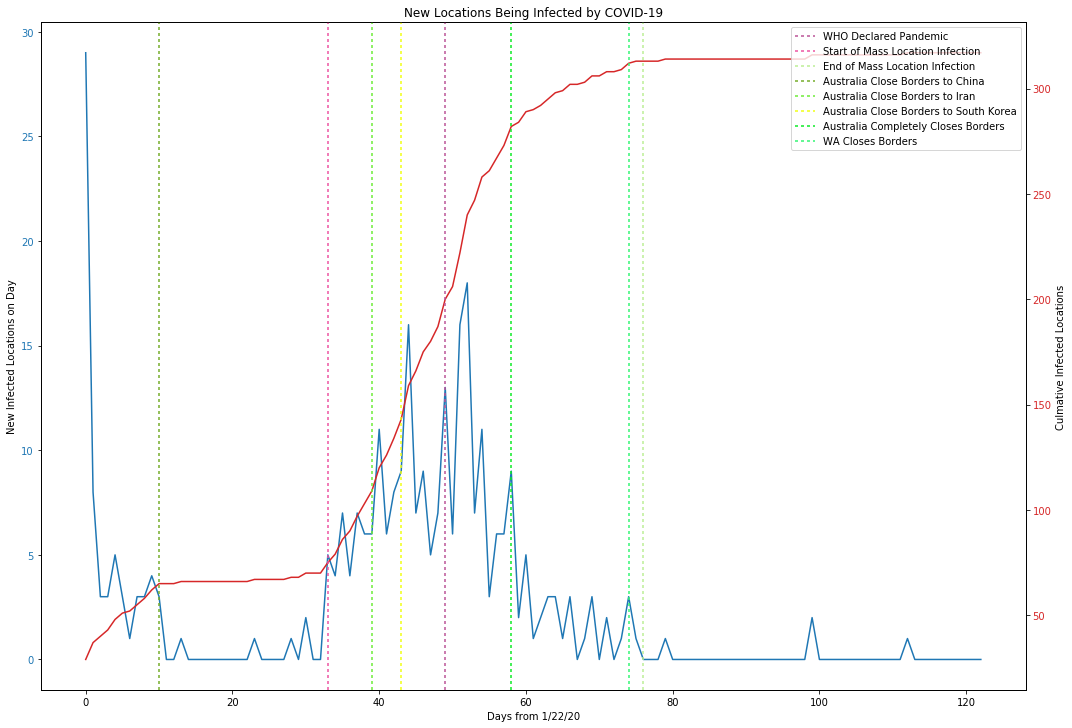

In [96]:
keypoints_timeline = {
    "WHO Declared Pandemic" : "3/11/20",
    "Start of Mass Location Infection" : "2/24/20",
    "End of Mass Location Infection" : "4/7/20",
    "Australia Close Borders to China" : "2/1/20",
    "Australia Close Borders to Iran" : "3/1/20",
    "Australia Close Borders to South Korea" : "3/5/20",
    "Australia Completely Closes Borders" : "3/20/20",
    "WA Closes Borders" : "4/5/20",
}

def plot_new_locations_infected(new_locs, dates, keypoints_timeline,
                                title="New Locations Being Infected by COVID-19"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(15,10))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('New Infected Locations on Day')
    ax0.plot(from_day_zero, new_infections, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
    
    ax2.legend(legend_list)
    fig.tight_layout()
    plt.title(title)
    plt.show()
    fig.savefig("./figures/statecountry_new_infections.png", bbox_inches='tight')

dates = get_dates(data_confirmed, bin_region_column)
plot_new_locations_infected(new_locs, dates, keypoints_timeline)

In [97]:
def get_routes_including_loc(node_loc, routes, from_node, bin_region_column):
    node_loc_split = node_loc.split(':')
    
    county_key = "{}County"
    state_key = "{}Province/State"
    country_key = "{}Country/Region"
    
    dir_str = "Arrival"
    if from_node:
        dir_str = "Depart"
    
    county_key = county_key.format(dir_str)
    state_key = state_key.format(dir_str)
    country_key = country_key.format(dir_str)
    
    if bin_region_column == 'county':
        return routes.loc[
            (routes[county_key] == node_loc_split[0]) &
            (routes[state_key] == node_loc_split[1]) &
            (routes[country_key] == node_loc_split[2])
        ]
    elif bin_region_column == 'state':
        return routes.loc[
            (routes[state_key] == node_loc_split[0]) &
            (routes[country_key] == node_loc_split[1])
        ]
    else:
        return routes.loc[
            (routes[country_key] == node_loc_split[0])
        ]

def get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, routes, dates, bin_region_column):
    total_infect_to_clean = [0 for ii in range(len(dates))]
    
    def join_to_node_loc_format(row, from_node, bin_region_column):
        county_key = "{}County"
        state_key = "{}Province/State"
        country_key = "{}Country/Region"

        dir_str = "Depart"
        if from_node:
            dir_str = "Arrival"
            
        county_key = county_key.format(dir_str)
        state_key = state_key.format(dir_str)
        country_key = country_key.format(dir_str)
        
        if bin_region_column == 'county':
            return "{}:{}:{}".format(row[county_key], row[state_key], row[country_key])
        elif bin_region_column == 'state':
            return "{}:{}".format(row[state_key], row[country_key])
        else:
            return "{}".format(row[country_key])
    
    for date_index in tqdm(range(len(dates))):
        date = dates[date_index]
        
        infect_graph = infect_graphs[date]
        infected_locations = infect_graph.nodes
        
        for infect_loc in infected_locations:
            from_node = False
            infect_routes = get_routes_including_loc(infect_loc, routes, from_node, bin_region_column)

            for _index, row in infect_routes.iterrows():
                
                other_node_loc = join_to_node_loc_format(row, from_node, bin_region_column)
                if not other_node_loc in infected_locations:
                    total_infect_to_clean[date_index] = total_infect_to_clean[date_index] + 1
                    
            from_node = True
            infect_routes = get_routes_including_loc(infect_loc, routes, from_node, bin_region_column)

            for _index, row in infect_routes.iterrows():
                other_node_loc = join_to_node_loc_format(row, from_node, bin_region_column)
                if not other_node_loc in infected_locations:
                    total_infect_to_clean[date_index] = total_infect_to_clean[date_index] + 1
    
    return total_infect_to_clean
                
        

In [98]:
total_infect_to_clean = get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, 
                                                                            routes, 
                                                                            dates, 
                                                                            bin_region_column)

100%|██████████| 123/123 [03:32<00:00,  1.73s/it]


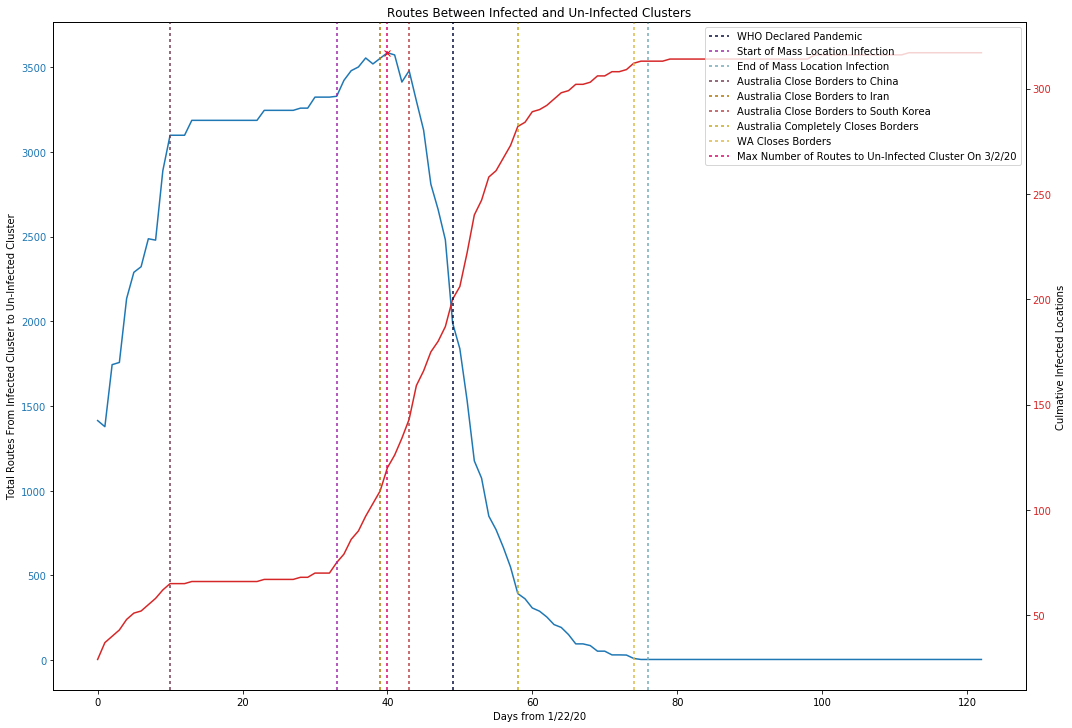

In [99]:
def plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline,
                                         title="Routes Between Infected and Un-Infected Clusters"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(15,10))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('Total Routes From Infected Cluster to Un-Infected Cluster')
    ax0.plot(from_day_zero, total_infect_to_clean, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
        
    max_total_paths = max(total_infect_to_clean)
    max_total_paths_index = total_infect_to_clean.index(max_total_paths)
    
    crit_label = 'Max Number of Routes to Un-Infected Cluster On {}'.format(dates[max_total_paths_index])
    ax0.plot(max_total_paths_index, max_total_paths, 'rx')
    ax2.axvline(max_total_paths_index, 0, max(new_infections_culm),
                label=crit_label, c=np.random.rand(3,), dashes=(2,2))
    legend_list.append(crit_label)
    
    ax2.legend(legend_list)
    fig.tight_layout()
    plt.title(title)
    plt.show()
    fig.savefig("./figures/statecountry_cluster_paths_test.png", bbox_inches='tight')
    
plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline)

In [127]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 0.20)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs_top_20, location_pos_top_20, max_confirmed_top_20, infected_parents_top_20, new_locs_top_20, new_edges_top_20 = get_infection_path(data_confirmed, 
                                                                                                                                                 routes, 
                                                                                                                                                 infect_thresh, 
                                                                                                                                                 bin_region_column,
                                                                                                                                                 border_closures=border_closures)

animation_top_20_percent = TimeMapAnimation(infect_graphs_top_20, 
                                            location_pos_top_20, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs_top_20, 
                                            new_edges_top_20,
                                            bin_region_column,
                                            verbose=True,
                                            period=0.1,
                                            dynamic_line_opacity=True
                                           )
animation_top_20_percent.displayMap()

 46%|████▌     | 56/123 [00:00<00:00, 553.60it/s]

INITIAL INFECTION THRESHOLD SET TO 16053.0


100%|██████████| 123/123 [00:09<00:00, 13.01it/s]


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [128]:
animation_top_20_percent.startAnimation()

Starting Animation in 5.0 seconds
Current Date: 1/22/20
Current Date: 1/23/20
Current Date: 1/24/20
Current Date: 1/25/20
Current Date: 1/26/20
Current Date: 1/27/20
Current Date: 1/28/20
Current Date: 1/29/20
Current Date: 1/30/20
Current Date: 1/31/20
Current Date: 2/1/20
Current Date: 2/2/20
Current Date: 2/3/20
Current Date: 2/4/20
Current Date: 2/5/20
Current Date: 2/6/20
Current Date: 2/7/20
Current Date: 2/8/20
Current Date: 2/9/20
Current Date: 2/10/20
Current Date: 2/11/20
Current Date: 2/12/20
Current Date: 2/13/20
Current Date: 2/14/20
Current Date: 2/15/20
Current Date: 2/16/20
Current Date: 2/17/20
Current Date: 2/18/20
Current Date: 2/19/20
Current Date: 2/20/20
Current Date: 2/21/20
Current Date: 2/22/20
Current Date: 2/23/20
Current Date: 2/24/20
Current Date: 2/25/20
Current Date: 2/26/20
Current Date: 2/27/20
Current Date: 2/28/20
Current Date: 2/29/20
Current Date: 3/1/20
Current Date: 3/2/20
Current Date: 3/3/20
Current Date: 3/4/20
Current Date: 3/5/20
Current Date

Current Date: 4/23/20
New Infected Location: none:Sweden
New Edge Between none:Italy and none:Sweden
New Edge Between none:Spain and none:Sweden
New Edge Between none:Germany and none:Sweden
New Edge Between none:France and none:Sweden
New Edge Between none:Belgium and none:Sweden
New Edge Between none:Netherlands and none:Sweden
New Edge Between none:Portugal and none:Sweden
New Edge Between none:Ireland and none:Sweden
Current Date: 4/24/20
New Infected Location: Maryland:US
New Infected Location: none:Ecuador
New Edge Between New York:US and Maryland:US
New Edge Between none:United Kingdom and Maryland:US
New Edge Between New Jersey:US and Maryland:US
New Edge Between Michigan:US and Maryland:US
New Edge Between Louisiana:US and Maryland:US
New Edge Between California:US and Maryland:US
New Edge Between Massachusetts:US and Maryland:US
New Edge Between Pennsylvania:US and Maryland:US
New Edge Between Illinois:US and Maryland:US
New Edge Between Florida:US and Maryland:US
New Edge Be

Current Date: 5/13/20
New Infected Location: North Carolina:US
New Infected Location: none:Ukraine
New Edge Between New York:US and North Carolina:US
New Edge Between none:United Kingdom and North Carolina:US
New Edge Between New Jersey:US and North Carolina:US
New Edge Between Michigan:US and North Carolina:US
New Edge Between Louisiana:US and North Carolina:US
New Edge Between California:US and North Carolina:US
New Edge Between Massachusetts:US and North Carolina:US
New Edge Between Pennsylvania:US and North Carolina:US
New Edge Between Illinois:US and North Carolina:US
New Edge Between Florida:US and North Carolina:US
New Edge Between Texas:US and North Carolina:US
New Edge Between Georgia:US and North Carolina:US
New Edge Between Connecticut:US and North Carolina:US
New Edge Between none:Ireland and North Carolina:US
New Edge Between Maryland:US and North Carolina:US
New Edge Between Ohio:US and North Carolina:US
New Edge Between Ontario:Canada and North Carolina:US
New Edge Betwe

In [8]:
len(infect_graphs['5/23/20'].edges)

5358

In [111]:
len(infect_graphs['5/23/20'].edges)

5175

In [118]:
new_edges_top_20

{'1/22/20': [],
 '1/23/20': [],
 '1/24/20': [],
 '1/25/20': [],
 '1/26/20': [],
 '1/27/20': [],
 '1/28/20': [],
 '1/29/20': [],
 '1/30/20': [],
 '1/31/20': [],
 '2/1/20': [],
 '2/2/20': [],
 '2/3/20': [],
 '2/4/20': [],
 '2/5/20': [],
 '2/6/20': [],
 '2/7/20': [],
 '2/8/20': [],
 '2/9/20': [],
 '2/10/20': [],
 '2/11/20': [],
 '2/12/20': [],
 '2/13/20': [],
 '2/14/20': [],
 '2/15/20': [],
 '2/16/20': [],
 '2/17/20': [],
 '2/18/20': [],
 '2/19/20': [],
 '2/20/20': [],
 '2/21/20': [],
 '2/22/20': [],
 '2/23/20': [],
 '2/24/20': [],
 '2/25/20': [],
 '2/26/20': [],
 '2/27/20': [],
 '2/28/20': [],
 '2/29/20': [],
 '3/1/20': [],
 '3/2/20': [],
 '3/3/20': [],
 '3/4/20': [],
 '3/5/20': [],
 '3/6/20': [],
 '3/7/20': [],
 '3/8/20': [],
 '3/9/20': [],
 '3/10/20': [],
 '3/11/20': [],
 '3/12/20': [],
 '3/13/20': [('Hubei:China', 'none:Italy')],
 '3/14/20': [],
 '3/15/20': [],
 '3/16/20': [],
 '3/17/20': [('none:Italy', 'none:Iran')],
 '3/18/20': [],
 '3/19/20': [('none:Italy', 'none:Spain'), ('none: